# Set-up

Imports

In [1]:
import json
import numpy as np
import jax.numpy as jnp
import surrojax_gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
sys.path.insert(0, '..')
import plotting_helpers

Plotting settings

In [2]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 100

Define directory of beam data and directory of where figures are saved:

In [3]:
data_dir = '../beam/data'
fig_save_dir = './figs/beam_data'
if not os.path.isdir(fig_save_dir):
    os.mkdir(fig_save_dir)

Functions to load beam data:

In [4]:
def load_beam_data(file_dir):
    with open(file_dir, 'r') as f:
        data = json.load(f)
    C_1 = jnp.array(data['C_1'])
    angles = jnp.array(data['beam_angle'])
    disp = jnp.array(data['end_disp'])
    C1_pts = jnp.unique(C_1.flatten())
    angle_pts = jnp.unique(angles.flatten())
    C1_grid, angle_grid = np.meshgrid(C1_pts, angle_pts)
    return {'C_1': C1_grid, 'beam_angle': angle_grid, 'end_disp': disp}

# Convergence Studies

In [5]:
sns.set_style('darkgrid')

In [6]:
with open(os.path.join(data_dir, 'neohookean_beam_meshsize_convergence.json'), 'r') as f:
    mesh_converge = json.load(f)
with open(os.path.join(data_dir, 'neohookean_beam_kappa_convergence.json'), 'r') as f:
    kappa_converge = json.load(f)

Mesh convergence:

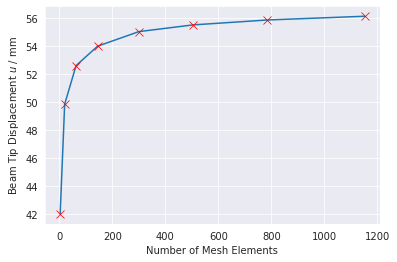

In [7]:
fig, ax = plt.subplots()
sns.lineplot(data=mesh_converge, x='num_elem', y='end_disp', marker='x', markersize=8, mec='r')
plt.xlabel('Number of Mesh Elements')
plt.ylabel('Beam Tip Displacement $u$ / mm')
plt.savefig(os.path.join(fig_save_dir, 'meshsize_convergence_disp.svg'))

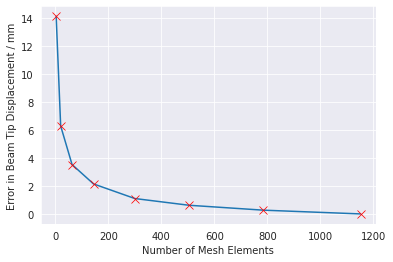

In [8]:
max_disp = np.max(mesh_converge['end_disp'])
abs_error = np.abs(mesh_converge['end_disp'] - max_disp)
fig, ax = plt.subplots()
sns.lineplot(x=mesh_converge['num_elem'], y=abs_error, marker='x', markersize=8, mec='r')
plt.xlabel('Number of Mesh Elements')
plt.ylabel('Error in Beam Tip Displacement / mm')
plt.savefig(os.path.join(fig_save_dir, 'meshsize_convergence_abs_err.svg'))
plt.show()

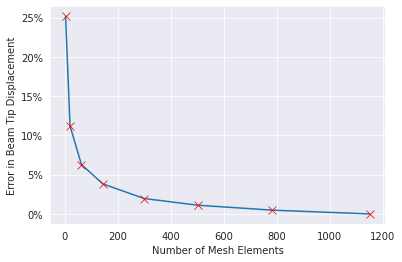

In [9]:
pct_error = 100*abs_error/max_disp
fig, ax = plt.subplots()
sns.lineplot(x=mesh_converge['num_elem'], y=pct_error, marker='x', markersize=8, mec='r')
plt.xlabel('Number of Mesh Elements')
plt.ylabel('Error in Beam Tip Displacement')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))
plt.savefig(os.path.join(fig_save_dir, 'meshsize_convergence_pct_err.svg'))

Kappa convergence

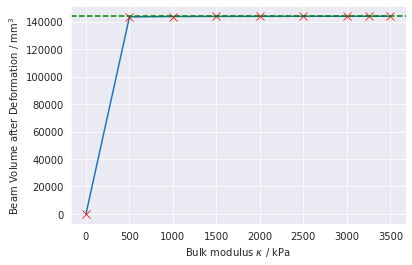

In [10]:
vols = np.array(kappa_converge['volume'])
init_vol = vols[0,0]
disp_vols = vols[:,1]
fig, ax = plt.subplots()
sns.lineplot(x=kappa_converge['kappa'], y=disp_vols, marker='x', markersize=8, mec='r')
plt.axhline(y=init_vol, color='green', linestyle='--')
plt.xlabel('Bulk modulus $\kappa$ / kPa')
plt.ylabel('Beam Volume after Deformation / mm$^3$')
plt.savefig(os.path.join(fig_save_dir, 'kappa_convergence_vol.svg'), bbox_inches='tight')

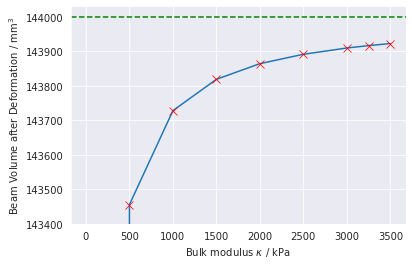

In [11]:
fig, ax = plt.subplots()
sns.lineplot(x=kappa_converge['kappa'], y=disp_vols, marker='x', markersize=8, mec='r')
plt.axhline(y=init_vol, color='green', linestyle='--')
plt.xlabel('Bulk modulus $\kappa$ / kPa')
plt.ylabel('Beam Volume after Deformation / mm$^3$')
ax.set_ylim(143400, 144030)
plt.savefig(os.path.join(fig_save_dir, 'kappa_convergence_vol_zoom.svg'), bbox_inches='tight')

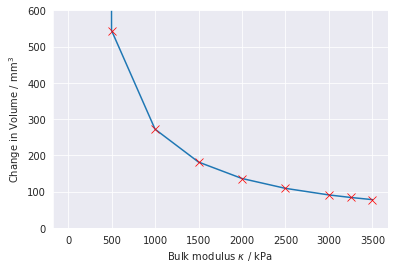

In [12]:
fig, ax = plt.subplots()
abs_error = np.abs(disp_vols - init_vol)
sns.lineplot(x=kappa_converge['kappa'], y=abs_error, marker='x', markersize=8, mec='r')
plt.xlabel('Bulk modulus $\kappa$ / kPa')
plt.ylabel('Change in Volume / mm$^3$')
ax.set_ylim(0, 600)
plt.savefig(os.path.join(fig_save_dir, 'kappa_convergence_abs.svg'), bbox_inches='tight')

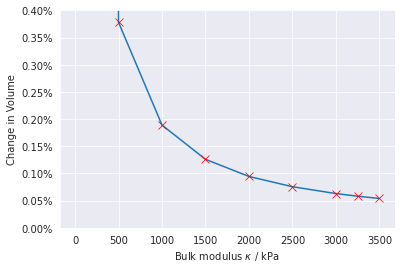

In [13]:
pct_error = 100*abs_error/init_vol
fig, ax = plt.subplots()
sns.lineplot(x=kappa_converge['kappa'], y=pct_error, marker='x', markersize=8, mec='r')
plt.xlabel('Bulk modulus $\kappa$ / kPa')
plt.ylabel('Change in Volume')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=2))
ax.set_ylim(0, 0.4)
plt.savefig(os.path.join(fig_save_dir, 'kappa_convergence_pct.svg'), bbox_inches='tight')

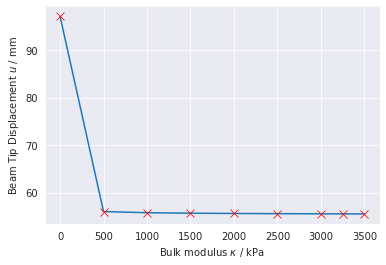

In [14]:
fig, ax = plt.subplots()
sns.lineplot(data=kappa_converge, x='kappa', y='end_disp', marker='x', markersize=8, mec='r')
plt.xlabel('Bulk modulus $\kappa$ / kPa')
plt.ylabel('Beam Tip Displacement $u$ / mm')
plt.savefig(os.path.join(fig_save_dir, 'kappa_convergence_disp.svg'), bbox_inches='tight')

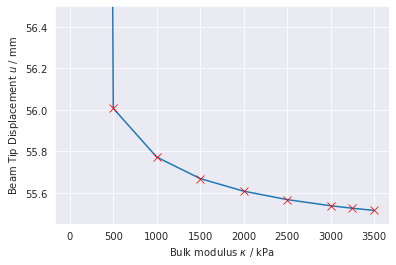

In [15]:
fig, ax = plt.subplots()
sns.lineplot(x=kappa_converge['kappa'], y=kappa_converge['end_disp'], marker='x', markersize=8, mec='r')
plt.xlabel('Bulk modulus $\kappa$ / kPa')
plt.ylabel('Beam Tip Displacement $u$ / mm')
ax.set_ylim(55.45, 56.5)
plt.savefig(os.path.join(fig_save_dir, 'kappa_convergence_disp_zoom.svg'), bbox_inches='tight')

In [16]:
plt.rcdefaults()

# Neo-Hookean Data

In [17]:
train_data = load_beam_data(os.path.join(data_dir, 'neohookean_beam_training_data.json'))
test_data = load_beam_data(os.path.join(data_dir, 'neohookean_beam_test_data.json'))

In [18]:
# Get max and min displacements for plotting purposes:
y_min = np.min(np.concatenate([train_data['end_disp'], test_data['end_disp']]))
y_max = np.max(np.concatenate([train_data['end_disp'], test_data['end_disp']]))

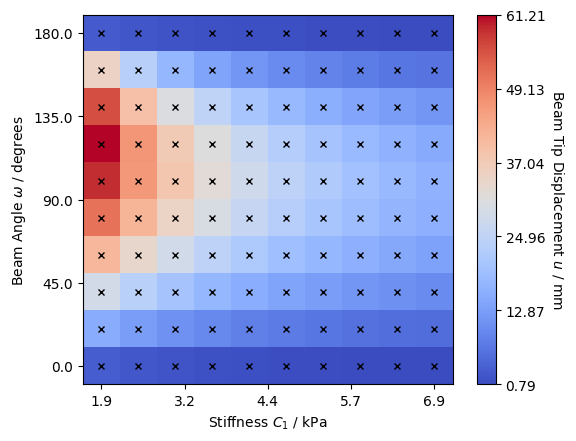

In [19]:
fig = plotting_helpers.plot_gp_heatmap(train_data['C_1'], train_data['beam_angle'], train_data['end_disp'], 
                                       raw_data=train_data, 
                                       num_C1_ticks=5, num_angle_ticks=5,
                                       x_label = 'Stiffness $C_1$ / kPa',
                                       y_label = 'Beam Angle $\omega$ / degrees',
                                       z_label='Beam Tip Displacement $u$ / mm', 
                                       z_lims = (y_min, y_max))
plt.savefig(os.path.join(fig_save_dir, 'training_raw.svg'))
fig.show()

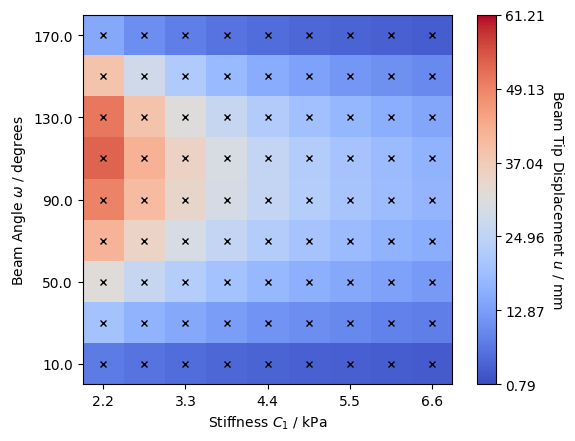

In [20]:
fig = plotting_helpers.plot_gp_heatmap(test_data['C_1'], test_data['beam_angle'], test_data['end_disp'], 
                                       raw_data=test_data, 
                                       num_C1_ticks=5, num_angle_ticks=5,
                                       x_label = 'Stiffness $C_1$ / kPa',
                                       y_label = 'Beam Angle $\omega$ / degrees',
                                       z_label= 'Beam Tip Displacement $u$ / mm', 
                                       z_lims = (y_min, y_max))
plt.savefig(os.path.join(fig_save_dir, 'test_raw.svg'))
fig.show()

Relationship between testing and training data points:

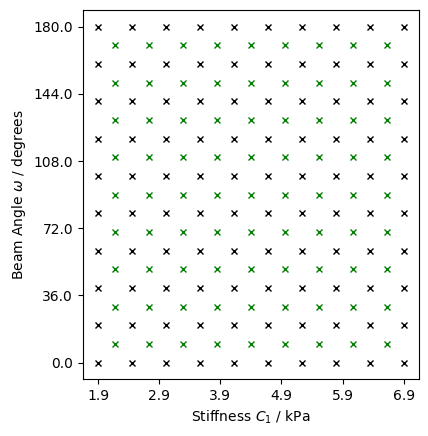

In [21]:
fig, ax = plt.subplots()
x_grid = train_data['C_1']
y_grid = train_data['beam_angle']
plotting_helpers.plot_gp_points_as_crosses(train_data, x_grid, y_grid, color='black')
plotting_helpers.plot_gp_points_as_crosses(test_data, x_grid, y_grid, color='green')
plotting_helpers.set_x_and_y_ticks(ax, train_data['C_1'], train_data['beam_angle'])
ax.set_ylabel('Beam Angle $\omega$ / degrees')
ax.set_xlabel('Stiffness $C_1$ / kPa')
plt.subplots_adjust(right=0.65)
plotting_helpers.clean_up_plot(fig)
plt.savefig(os.path.join(fig_save_dir, 'train_test_pos.svg'))
fig.show()

# Linear Beam

In [22]:
linear_data = load_beam_data(os.path.join(data_dir, 'linear_beam_training_data.json'))

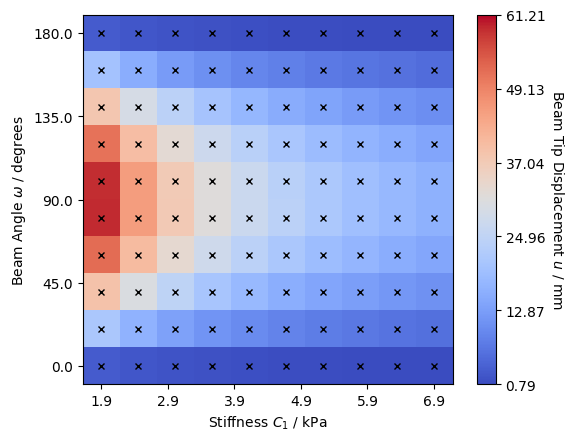

In [23]:
fig = plotting_helpers.plot_gp_heatmap(linear_data['C_1'], linear_data['beam_angle'], linear_data['end_disp'], 
                                       raw_data=linear_data, 
                                       x_label = 'Stiffness $C_1$ / kPa',
                                       y_label = 'Beam Angle $\omega$ / degrees',
                                       z_label='Beam Tip Displacement $u$ / mm', 
                                       z_lims = (y_min, y_max))
plt.savefig(os.path.join(fig_save_dir, 'linear_raw.svg'))
fig.show()